In [149]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
import scipy.special
import copy
#import sklearn.datasets
import scipy.sparse as sparse
from scipy.sparse import csr_matrix, linalg
import time
from scipy.io import loadmat, savemat
import re
import torch as t
import pandas as pd

In [150]:
device=t.device("cuda:0")

In [151]:
class Fairness_Learning:
    def __init__(self,A,b,c,lamb,gamma,beta):
        self.m,self.dim=A.shape
        self.d=self.dim+1
        self.gamma=gamma
        self.beta=beta
        self.A=A.to(device)
        self.lamb=lamb
        self.b=b.to(device)
        self.c=c.to(device)
    
        
    def grad(self,z,Ax):
        x=z[:self.dim]
        y=z[self.dim]
        p1=1/(1+t.exp(self.b*Ax))
        p2=1/(1+t.exp(self.c*(Ax)*y))
        gx=-self.A.T@(p1*self.b/self.m)+self.A.T@(self.c*y*p2*self.beta/self.m)+2*self.lamb*x
        gy=t.sum((Ax)*self.c*self.beta*p2/self.m)-2*self.gamma*y
        g=t.zeros(self.d,1).double().to(device)
        g[:self.dim]=gx
        g[self.dim]=gy
        return g

    def Hxy(self, z):
        x=z[:self.dim]
        y=z[self.dim]
        multt=self.A@x
        p2=1/(1+t.exp(self.c*(multt)*y))
        H_xy = -self.A.T@((self.A@x)*y*p2*(1-p2)*self.beta/self.m)+self.A.T@(p2*self.beta/self.m*self.c)
        return H_xy.double().to(device)

    def Hyy(self, z):
        x=z[:self.dim]
        y=z[self.dim]
        multt=self.A@x
        p2=1/(1+t.exp(self.c*(multt)*y))
        H_yy = t.Tensor([[-t.sum(p2*(1-p2)/self.m*self.beta*(self.A@x)**2)-2*self.gamma]])
        return H_yy.double().to(device)
    
    def hes(self,z):
        x=z[:self.dim]
        y=z[self.dim]
        multt=self.A@x
        p1=1/(1+t.exp(self.b*multt))
        p2=1/(1+t.exp(self.c*(multt)*y))
        Hxx=self.A.T@(p1*(1-p1)/self.m*self.A)-self.A.T@(p2*(1-p2)*self.beta/self.m*y**2*self.A)+2*self.lamb*t.eye(self.dim).double().to(device)
        Hyy=-t.sum(p2*(1-p2)/self.m*self.beta*(self.A@x)**2)-2*self.gamma
        Hxy=-self.A.T@((self.A@x)*y*p2*(1-p2)*self.beta/self.m)+self.A.T@(p2*self.beta/self.m*self.c)
        H=t.eye(self.d).double().to(device)
        H[:self.dim,:self.dim]=Hxx
        H[self.dim,self.dim]=Hyy
        H[:self.dim,self.dim]=Hxy.reshape(-1)
        H[self.dim,:self.dim]=Hxy.reshape(-1)
        return H
    
    def hes_vec(self,z,v,Ax):
        x=z[:self.dim]
        y=z[self.dim]
        vx=v[:self.dim]
        vy=v[self.dim]
        p1=1/(1+t.exp(self.b*Ax))
        p2=1/(1+t.exp(self.c*(Ax)*y))
        Avx=self.A@vx
        hxx=self.A.T@((p1*(1-p1)/self.m-p2*(1-p2)*self.beta/self.m*y**2)*(Avx))+2*self.lamb*vx
        hxy=-self.A.T@((Ax)*y*p2*(1-p2)*self.beta/self.m)*vy+self.A.T@(p2*self.beta/self.m*(self.c))*vy
        hyx=t.sum(-self.beta/self.m*p2*(1-p2)*(Ax)*y*(Avx))+t.sum(p2*self.beta/self.m*self.c*Avx)
        hyy=(-t.sum(p2*(1-p2)/self.m*self.beta*(Ax)**2)-2*self.gamma)*vy
        hv=t.zeros(self.d,1).double().to(device)
        hv[:self.dim]=hxx+hxy
        hv[self.dim]=hyy+hyx
        return hv
    
    def hes_vec_x(self, z, v, Ax):
        y = z[self.dim]
        p1=1/(1+t.exp(self.b*Ax))
        p2=1/(1+t.exp(self.c*(Ax)*y))
        Avx=self.A@v
        hv=self.A.T@((p1*(1-p1)/self.m-p2*(1-p2)*self.beta/self.m*y**2)*(Avx))+2*self.lamb*v
        return hv.double().to(device)

    def hes_diag_x(self, z, Ax):
        y = z[self.dim]
        p1=1/(1+t.exp(self.b*Ax))
        p2=1/(1+t.exp(self.c*(Ax)*y))
        temp1 = (p1 * (1 - p1) * self.A ** 2).sum(dim=0) / self.m
        temp2 = (p2 * (1 - p2) * self.A ** 2).sum(dim=0) * self.beta * y ** 2 / self.m
        hes_diag_vec = 2 * self.lamb + temp1 - temp2
        return hes_diag_vec.double().to(device)

In [152]:
def randomSR1_sol(w,L,epochs,M,corr=False):
    d=oracle.d
    invG = 1/L * t.eye(d).double().to(device)
    Ax=oracle.A@w[:oracle.dim]
    gw = oracle.grad(w,Ax)
    res = [t.linalg.norm(gw)]
    ts = time.time()
    times= [0]
    for i in range(epochs):
        dw = - invG @ (oracle.hes_vec(w,gw,Ax))
        if corr:
            r = t.sqrt(dw.T @ dw)
            invG /=  (1 + M * r) # proposed by authors
        w = w + dw
        Ax=oracle.A@w[:oracle.dim]
        gw = oracle.grad(w,Ax)

        u = t.randn(d,1).double().to(device)
        u=u/t.linalg.norm(u)

        Au = oracle.hes_vec(w,u,Ax)
        Hu = oracle.hes_vec(w, Au,Ax).reshape(d,1)
        v = invG @ Hu
        temp=u.T@(oracle.hes_vec(w,oracle.hes_vec(w,u-v,Ax),Ax))+1e-30
  #  temp=u.T @ oracle.hes_vec(oracle.hes_vec(u-v))
        invG += (u - v) @ ((u - v).T / temp )
        res.append(t.linalg.norm(gw))
        times.append(time.time()-ts)
        if(i%50==0):
        # Eigv=t.linalg.eigh(t.eye(oracle.dim+3).double().to(device)-oracle.Hessian@invG@oracle.Hessian)[0]
            print("epoches: ",i,"gradient norm:" ,res[-1].item())
        #I-HinvGH: ", Eigv[0])

        # if M < 10:
        #     M=M*1.001
        # if res[-1]<1e-7:
        #     M=10
        # elif res[-1]<1e-9:
        #     M=M*10
    return w,res,times

In [153]:
def inverse(invGxx, Hxy, Hyy):
    C2 = Hyy - Hxy.T @ invGxx @ Hxy
    temp = invGxx @ Hxy
    invC1 = invGxx + temp @ t.inverse(C2) @ temp.T
    invGxy = -invC1 @ Hxy @ t.inverse(Hyy)

    invG = t.zeros(oracle.d, oracle.d).double().to(device)
    invG[:oracle.d - 1, :oracle.d - 1] = invC1
    invG[:oracle.d - 1, oracle.d - 1: oracle.d] = invGxy
    invG[oracle.d - 1: oracle.d, :oracle.d - 1] = invGxy.T
    invG[oracle.d - 1, oracle.d - 1] = t.inverse(C2)

    return invG

In [154]:
def fast_randomSR1_sol(w, L, epochs, M, corr=False):
    d = oracle.d
    invGxx = 1 / L * t.eye(d - 1).double().to(device)
    Hxy = oracle.Hxy(w)
    Hyy = oracle.Hyy(w)
    invG = inverse(invGxx, Hxy, Hyy)
    Ax = oracle.A @ w[:oracle.dim]
    gw = oracle.grad(w, Ax)
    res = [t.linalg.norm(gw)]
    ts = time.time()
    times= [0]
    for i in range(epochs):
        dw = -invG @ gw
        if corr:
            r = t.linalg.norm(dw)
            invGxx = invGxx / (1 + M * r)
        w = w + dw
        Ax = oracle.A @ w[:oracle.dim]
        gw = oracle.grad(w, Ax)

        u = t.randn(d - 1, 1).double().to(device)
        u = u / t.linalg.norm(u)
        Au = oracle.hes_vec_x(w, u, Ax)
        v = invGxx @ Au
        temp = u.T @ (oracle.hes_vec_x(w, u - v, Ax)) + 1e-30
        invGxx += (u - v) @ ((u - v).T / temp )
        Hxy = oracle.Hxy(w)
        Hyy = oracle.Hyy(w)
        C2 = Hyy - Hxy.T @ invGxx @ Hxy
        temp = invGxx @ Hxy
        invC1 = invGxx + temp @ (1/C2) @ temp.T
        invGxy = -invC1 @ (Hxy @ (1/Hyy))
        invG[:oracle.d - 1, :oracle.d - 1] = invC1
        invG[:oracle.d - 1, oracle.d - 1: oracle.d] = invGxy
        invG[oracle.d - 1: oracle.d, :oracle.d - 1] = invGxy.T
        invG[oracle.d - 1, oracle.d - 1] = (1/C2)
        res.append(t.linalg.norm(gw))
        times.append(time.time()-ts)
        if(i%50==0):
            print("epoches: ",i,"gradient norm:" ,res[-1].item())
        
    return w,res,times

In [155]:
def fast_greedySR1_sol(w, L, epochs, M, corr=False):
    d = oracle.d
    Gxx = L * t.eye(oracle.d - 1).double().to(device)
    invGxx = 1 / L * t.eye(d - 1).double().to(device)
    Hxy = oracle.Hxy(w)
    Hyy = oracle.Hyy(w)
    invG = inverse(invGxx, Hxy, Hyy)
    Ax = oracle.A @ w[:oracle.dim]
    gw = oracle.grad(w, Ax)
    res = [t.linalg.norm(gw)]
    ts = time.time()
    times= [0]
    for i in range(epochs):
        dw = -invG @ gw
        if corr:
            r = t.linalg.norm(dw)
            invGxx = invGxx/ (1 + M * r)
            Gxx = Gxx * (1 + M * r)
        w = w + dw
        Ax = oracle.A @ w[:oracle.dim]
        gw = oracle.grad(w, Ax)

        ind = t.argmax(Gxx.diag() - oracle.hes_diag_x(w, Ax))
        u = t.zeros([d - 1, 1]).double().to(device)
        u[ind] = 1

        Gxxu = Gxx @ u
        Au = oracle.hes_vec_x(w, u, Ax)
        Gxx = Gxx - (Gxxu - Au) @ (Gxxu - Au).T / (u.T @ (Gxxu - Au) + 1e-20)
        
        v = invGxx @ Au
        temp = u.T @ (oracle.hes_vec_x(w, u - v, Ax)) + 1e-30
        invGxx += (u - v) @ ((u - v).T / temp )
        Hxy = oracle.Hxy(w)
        Hyy = oracle.Hyy(w)
        C2 = Hyy - Hxy.T @ invGxx @ Hxy
        temp = invGxx @ Hxy
        invC1 = invGxx + temp @ (1/C2) @ temp.T
        invGxy = -invC1 @ (Hxy @ (1/Hyy))
        invG[:oracle.d - 1, :oracle.d - 1] = invC1
        invG[:oracle.d - 1, oracle.d - 1: oracle.d] = invGxy
        invG[oracle.d - 1: oracle.d, :oracle.d - 1] = invGxy.T
        invG[oracle.d - 1, oracle.d - 1] = (1/C2)
        res.append(t.linalg.norm(gw))
        times.append(time.time()-ts)
        if(i%50==0):
            print("epoches: ",i,"gradient norm:" ,res[-1].item())
        
    return w,res,times

In [156]:
def randomBroyden_sol(w,L,epochs,M,corr=True):
    G=L*t.eye(oracle.d).double().to(device)
    invG = 1/L * t.eye(oracle.d).double().to(device)
    Ax=oracle.A@w[:oracle.dim]
    gw = oracle.grad(w,Ax)
    d=oracle.d
    res = [t.linalg.norm(gw)]
    ts = time.time()
    times= [0]
 #   print(res[-1])
    for i in range(epochs):
        dw = - invG @ oracle.hes_vec(w,gw,Ax)
        if corr:
            r = t.linalg.norm(dw)
            invG /= (1 + M * r) # proposed by authors
        w = w + dw
        Ax=oracle.A@w[:oracle.dim]
        u = t.randn(d, 1).double().to(device)
        #Gu = G @ u
        Au = oracle.hes_vec(w,u,Ax)
        Hu = oracle.hes_vec(w,Au,Ax).reshape(oracle.d,1)
        
        #G = G - Gu @ (Gu.T / (u.T @ Gu)) + Hu @ (Hu.T / (Au.T @ Au))
        
        
        v = u.T @ Hu
        tmp = (invG @ Hu) @ (u.T / v)
        invG += - tmp.T - tmp + u @ ((Hu.T @ tmp+u.T) / v) 
        gw = oracle.grad(w,Ax)
        res.append(t.linalg.norm(gw))
        times.append(time.time()-ts)
        if(i%50==0):
            print("epoches:",i,", gradient norm:", res[-1].item())
    print(res[-1])
    return w,res,times

In [157]:
def fast_randomBroyd_sol(w, L, epochs, M, corr=False):
    d = oracle.d
    invGxx = 1 / L * t.eye(d - 1).double().to(device)
    Hxy = oracle.Hxy(w)
    Hyy = oracle.Hyy(w)
    invG = inverse(invGxx, Hxy, Hyy)
    Ax = oracle.A @ w[:oracle.dim]
    gw = oracle.grad(w, Ax)
    res = [t.linalg.norm(gw)]
    ts = time.time()
    times= [0]
    for i in range(epochs):
        dw = -invG @ gw
        if corr:
            r = t.linalg.norm(dw)
            invGxx = invGxx / (1 + M * r)
        w = w + dw
        Ax = oracle.A @ w[:oracle.dim]
        gw = oracle.grad(w, Ax)

        u = t.randn(d - 1, 1).double().to(device)
        u = u / t.linalg.norm(u)

        Au = oracle.hes_vec_x(w, u, Ax).reshape(d-1,1)
        v = u.T @ Au
        tmp = (invGxx @ Au) @ (u.T / v)
        invGxx = invGxx - tmp.T - tmp + u @ ((Au.T @ tmp) / v) + u @ (u.T / v)
        Hxy = oracle.Hxy(w)
        Hyy = oracle.Hyy(w)
        C2 = Hyy - Hxy.T @ invGxx @ Hxy
        temp = invGxx @ Hxy
        invC1 = invGxx + temp @ (1/C2) @ temp.T
        invGxy = -invC1 @ (Hxy @ (1/Hyy))
        invG[:oracle.d - 1, :oracle.d - 1] = invC1
        invG[:oracle.d - 1, oracle.d - 1: oracle.d] = invGxy
        invG[oracle.d - 1: oracle.d, :oracle.d - 1] = invGxy.T
        invG[oracle.d - 1, oracle.d - 1] = (1/C2)
        res.append(t.linalg.norm(gw))
        times.append(time.time()-ts)
        if(i%50==0):
            print("epoches: ",i,"gradient norm:" ,res[-1].item())
        
    return w,res,times

In [158]:
def fast_greedyBroyd_sol(w, L, epochs, M, corr=False):
    d = oracle.d
    Gxx = L * t.eye(d-1).double().to(device)
    invGxx = 1 / L * t.eye(d - 1).double().to(device)
    Hxy = oracle.Hxy(w)
    Hyy = oracle.Hyy(w)
    invG = inverse(invGxx, Hxy, Hyy)
    Ax = oracle.A @ w[:oracle.dim]
    gw = oracle.grad(w, Ax)
    res = [t.linalg.norm(gw)]
    ts = time.time()
    times= [0]
    for i in range(epochs):
        dw = -invG @ gw
        if corr:
            r = t.linalg.norm(dw)
            invGxx = invGxx / (1 + M * r)
            Gxx=Gxx*(1+M*r)
        w = w + dw
        Ax = oracle.A @ w[:oracle.dim]
        gw = oracle.grad(w, Ax)
  #    print(Gxx.diag().shape)
        ind = t.argmax(Gxx.diag() / oracle.hes_diag_x(w,Ax))
        u = t.zeros([d-1, 1]).double().to(device)
        u[ind]=1
        Gxxu=Gxx@u
        Au = oracle.hes_vec_x(w, u, Ax).reshape(d-1,1)
        Gxx = Gxx - Gxxu @ (Gxxu.T / (u.T @ Gxxu)) + Au @ (Au.T / (u.T @ Au))
        v = u.T @ Au
        tmp = (invGxx @ Au) @ (u.T / v)
        invGxx = invGxx - tmp.T - tmp + u @ ((Au.T @ tmp) / v) + u @ (u.T / v)
        Hxy = oracle.Hxy(w)
        Hyy = oracle.Hyy(w)
        C2 = Hyy - Hxy.T @ invGxx @ Hxy
        temp = invGxx @ Hxy
        invC1 = invGxx + temp @ (1/C2) @ temp.T
        invGxy = -invC1 @ (Hxy @ (1/Hyy))
        invG[:oracle.d - 1, :oracle.d - 1] = invC1
        invG[:oracle.d - 1, oracle.d - 1: oracle.d] = invGxy
        invG[oracle.d - 1: oracle.d, :oracle.d - 1] = invGxy.T
        invG[oracle.d - 1, oracle.d - 1] = (1/C2)     
        res.append(t.linalg.norm(gw))
        times.append(time.time()-ts)
        if(i%50==0):
            print("epoches: ",i,"gradient norm:" ,res[-1].item())
        
    return w,res,times

In [159]:
def Extra_gradiant(w,alpha,beta,epochs):
    Ax=oracle.A@w[:oracle.dim]
    gw = oracle.grad(w,Ax)
    dim=oracle.dim
    res = [t.linalg.norm(gw)]
    w1=t.zeros(oracle.d,1).double().to(device)
    ts = time.time()
    times= [0]
    for i in range(epochs):
        gx =gw[:dim]
        gy=gw[oracle.dim]
        x=w[:oracle.dim]
        y=w[oracle.dim]
        x1=x-alpha*gx
        y1=y+alpha*gy
        w1[:oracle.dim]=x1
        w1[oracle.dim]=y1
        Ax1=oracle.A@x1
        gw= oracle.grad(w1,Ax1)
        gx1 =gw[:oracle.dim]
        gy1=gw[oracle.dim]
        x=x-beta*gx1
        y=y+beta*gy1
        w[:oracle.dim]=x
        w[oracle.dim]=y
        Ax=oracle.A@x
        gw = oracle.grad(w,Ax)
        res.append(t.linalg.norm(gw))
        times.append(time.time()-ts)
        if(i%50==0):
            print("epoches:",i,", gradient norm:", res[-1].item())
    print(res[-1])
    return w,res,times

## A9a Dataset

In [240]:
m = loadmat('a9a.mat')
A0=np.array(m['A']).astype("float")
b=np.array(m['b']).astype("float")
c=A0[:,71]
A=np.hstack((A0[:,:71],A0[:,72:]))
c[np.where(c==0)[0]]=-1
c=c.reshape(A0.shape[0],1)
A=t.from_numpy(A).double()
b=t.from_numpy(b).double()
c=t.from_numpy(c).double()

In [64]:
A.shape[0]

32561

In [286]:
oracle = Fairness_Learning(A,b,c,lamb=0.0001,gamma=0.0001,beta=0.5)

In [287]:
w0=t.zeros(oracle.d,1).double().to(device)
weg,reg,teg=Extra_gradiant(w0,0.5,0.5,10000)

epoches: 0 , gradient norm: 0.5287819954628016
epoches: 50 , gradient norm: 0.03281374534912373
epoches: 100 , gradient norm: 0.01903823123835645
epoches: 150 , gradient norm: 0.01337250846073959
epoches: 200 , gradient norm: 0.010205437535330104
epoches: 250 , gradient norm: 0.008204137059493619
epoches: 300 , gradient norm: 0.0068340942454046694
epoches: 350 , gradient norm: 0.005839519581711212
epoches: 400 , gradient norm: 0.005084698511775065
epoches: 450 , gradient norm: 0.004491742215943755
epoches: 500 , gradient norm: 0.004013054393394415
epoches: 550 , gradient norm: 0.0036180399734720334
epoches: 600 , gradient norm: 0.003286202301752659
epoches: 650 , gradient norm: 0.003003328529136878
epoches: 700 , gradient norm: 0.0027592684810340724
epoches: 750 , gradient norm: 0.0025465837445006723
epoches: 800 , gradient norm: 0.002359695713986966
epoches: 850 , gradient norm: 0.0021943317987748374
epoches: 900 , gradient norm: 0.002047156121169006
epoches: 950 , gradient norm: 0.00

In [288]:
z0=(weg).to("cpu")

In [289]:
wb,rbroyden,tbroyden=randomBroyden_sol(copy.deepcopy(z0).to(device),1,3000,0,True)

epoches: 0 , gradient norm: 0.00010382214604190793
epoches: 50 , gradient norm: 0.00010380955261978723
epoches: 100 , gradient norm: 0.00010377594781558539
epoches: 150 , gradient norm: 0.00010367312903420873
epoches: 200 , gradient norm: 0.00010350861187618336
epoches: 250 , gradient norm: 0.00010325627305309721
epoches: 300 , gradient norm: 0.000102955898761973
epoches: 350 , gradient norm: 0.00010258388362486939
epoches: 400 , gradient norm: 0.00010215833860765475
epoches: 450 , gradient norm: 0.00010167602455591905
epoches: 500 , gradient norm: 0.00010109347224835695
epoches: 550 , gradient norm: 0.0001004413573066335
epoches: 600 , gradient norm: 9.968475541217558e-05
epoches: 650 , gradient norm: 9.883323644801414e-05
epoches: 700 , gradient norm: 9.789696532498101e-05
epoches: 750 , gradient norm: 9.687752407467649e-05
epoches: 800 , gradient norm: 9.581596768156628e-05
epoches: 850 , gradient norm: 9.470934631574398e-05
epoches: 900 , gradient norm: 9.35355995913695e-05
epoches

In [290]:
wb,rabroydfast,tbroyfast1=fast_randomBroyd_sol(copy.deepcopy(z0).to(device),10,3000,1,True)

epoches:  0 gradient norm: 0.00010381864998182779
epoches:  50 gradient norm: 0.0001558320597126112
epoches:  100 gradient norm: 0.000125643814139333
epoches:  150 gradient norm: 8.001022193926912e-05
epoches:  200 gradient norm: 3.4986967995789455e-05
epoches:  250 gradient norm: 1.6576654654092436e-05
epoches:  300 gradient norm: 6.436434957887959e-06
epoches:  350 gradient norm: 1.9075207166983945e-06
epoches:  400 gradient norm: 4.382626600979224e-07
epoches:  450 gradient norm: 4.087180478602084e-08
epoches:  500 gradient norm: 2.8000897633170672e-09
epoches:  550 gradient norm: 1.308670165005261e-10
epoches:  600 gradient norm: 4.734327671140702e-12
epoches:  650 gradient norm: 7.214819677256128e-14
epoches:  700 gradient norm: 1.0741913308489946e-15
epoches:  750 gradient norm: 9.863234828588234e-18
epoches:  800 gradient norm: 3.790683236275599e-17
epoches:  850 gradient norm: 1.0939378109802488e-17
epoches:  900 gradient norm: 1.1238224189596827e-17
epoches:  950 gradient norm

In [291]:
w4, broyd_fast_gr, tbroydr = fast_greedyBroyd_sol(copy.deepcopy(z0).to(device), 100, 3000, 1,True)

epoches:  0 gradient norm: 0.00010382180755406242
epoches:  50 gradient norm: 0.00012358804153860298
epoches:  100 gradient norm: 0.00011287022140936921
epoches:  150 gradient norm: 1.0997422801458202e-05
epoches:  200 gradient norm: 2.810024655887098e-06
epoches:  250 gradient norm: 3.2869403436239376e-07
epoches:  300 gradient norm: 1.9365888714885207e-08
epoches:  350 gradient norm: 6.899573876783299e-10
epoches:  400 gradient norm: 1.3528076121542342e-11
epoches:  450 gradient norm: 9.506829978034448e-14
epoches:  500 gradient norm: 2.573870204225205e-16
epoches:  550 gradient norm: 1.48640350377486e-17
epoches:  600 gradient norm: 3.5087390998211964e-17
epoches:  650 gradient norm: 6.87416169489085e-17
epoches:  700 gradient norm: 2.077290994760117e-17
epoches:  750 gradient norm: 4.837758537607241e-17
epoches:  800 gradient norm: 4.477633254663795e-17
epoches:  850 gradient norm: 2.5704904850083008e-17
epoches:  900 gradient norm: 3.405857781457943e-17
epoches:  950 gradient norm

In [292]:
wsr1,rsr1,tsr1=randomSR1_sol(copy.deepcopy(z0).to(device),1000,2000,1,True)

epoches:  0 gradient norm: 0.00010382215870086313
epoches:  50 gradient norm: 0.00010325688311416055
epoches:  100 gradient norm: 9.542688190744475e-05
epoches:  150 gradient norm: 8.01043621794206e-05
epoches:  200 gradient norm: 6.511817298752594e-05
epoches:  250 gradient norm: 4.989446611557639e-05
epoches:  300 gradient norm: 3.7553188616811166e-05
epoches:  350 gradient norm: 2.8275245013331285e-05
epoches:  400 gradient norm: 2.1457970497093748e-05
epoches:  450 gradient norm: 1.5272316960311776e-05
epoches:  500 gradient norm: 1.0388882757749446e-05
epoches:  550 gradient norm: 6.4610725791183225e-06
epoches:  600 gradient norm: 3.5122385442005267e-06
epoches:  650 gradient norm: 1.602683215360206e-06
epoches:  700 gradient norm: 5.615612959061555e-07
epoches:  750 gradient norm: 1.6307328299655765e-07
epoches:  800 gradient norm: 2.7995107327402822e-08
epoches:  850 gradient norm: 2.9721498358087826e-09
epoches:  900 gradient norm: 6.629490605062213e-11
epoches:  950 gradient 

In [293]:
wsr_fast, rsr1_fast, tsr1_fast = fast_randomSR1_sol(copy.deepcopy(z0).to(device), 1, 2000, 1, True)

epoches:  0 gradient norm: 0.00010378707472060985
epoches:  50 gradient norm: 0.00013415115797115007
epoches:  100 gradient norm: 0.00010044376713342258
epoches:  150 gradient norm: 3.78919261614799e-05
epoches:  200 gradient norm: 9.33802108815393e-06
epoches:  250 gradient norm: 4.422810996524839e-07
epoches:  300 gradient norm: 2.72190416067009e-11
epoches:  350 gradient norm: 2.571781116227108e-17
epoches:  400 gradient norm: 2.993800995911906e-17
epoches:  450 gradient norm: 1.4876075379452966e-17
epoches:  500 gradient norm: 1.3172784174299327e-17
epoches:  550 gradient norm: 9.709875934365448e-18
epoches:  600 gradient norm: 3.745001025994168e-17
epoches:  650 gradient norm: 1.392097854285986e-17
epoches:  700 gradient norm: 5.690404632119901e-17
epoches:  750 gradient norm: 1.3424642545943512e-17
epoches:  800 gradient norm: 2.7368262023232847e-17
epoches:  850 gradient norm: 3.770489841817102e-17
epoches:  900 gradient norm: 2.082894319255336e-17
epoches:  950 gradient norm: 2

In [294]:
wgsr_fast, gsr_fast, tgsr_fast = fast_greedySR1_sol(copy.deepcopy(z0).to(device), 100, 2000, 1, True)

epoches:  0 gradient norm: 0.00010382180755406242
epoches:  50 gradient norm: 0.00012358679811200343
epoches:  100 gradient norm: 7.47066539561106e-05
epoches:  150 gradient norm: 1.563144758019173e-08
epoches:  200 gradient norm: 5.3863183012673715e-17
epoches:  250 gradient norm: 1.4798720571454073e-17
epoches:  300 gradient norm: 4.5782752151842746e-17
epoches:  350 gradient norm: 1.520439883417877e-17
epoches:  400 gradient norm: 6.3618399810148675e-18
epoches:  450 gradient norm: 4.7086081788225696e-17
epoches:  500 gradient norm: 7.975453006900342e-18
epoches:  550 gradient norm: 1.2485623008171034e-17
epoches:  600 gradient norm: 8.161767909898817e-18
epoches:  650 gradient norm: 2.857444584728705e-17
epoches:  700 gradient norm: 3.372787534182065e-17
epoches:  750 gradient norm: 3.687328900618252e-17
epoches:  800 gradient norm: 9.508901529417804e-18
epoches:  850 gradient norm: 3.627870736127386e-17
epoches:  900 gradient norm: 2.7652929437627386e-17
epoches:  950 gradient nor

In [295]:
rsr1=np.array([x.item() for x in rsr1])
rsr_fast = np.array([x.item() for x in rsr1_fast])
grsr1=np.array([x.item() for x in gsr_fast])
rbfgs=np.array([x.item() for x in rbroyden])
rbfgs_fast=np.array([x.item() for x in rabroydfast])
grbfgs=np.array([x.item() for x in broyd_fast_gr])
#file="faira9awarm"+warm_up+"res.pdf"

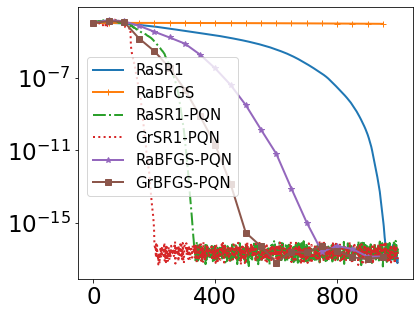

In [296]:
plt.rcParams['figure.figsize'] = (6, 5)
params = {'legend.fontsize': 15,
          'legend.handlelength': 2}
plt.rcParams.update(params)
plt.plot(rsr1[:1000], '-', label='RaSR1',  linewidth=2)
plt.plot(np.arange(0, len(rbfgs_fast[:1000]), 50), rbfgs[:1000:50],'-+', label='RaBFGS', linewidth=2)
plt.plot(rsr_fast[:1000], '-.', label='RaSR1-PQN', linewidth=2)
plt.plot(grsr1[:1000], ':', label='GrSR1-PQN', linewidth=2)
plt.plot(np.arange(0, len(rbfgs_fast[:1000]), 50), rbfgs_fast[:1000:50], '-*', label='RaBFGS-PQN', linewidth=2)
plt.plot(np.arange(0, len(rbfgs_fast[:1000]), 50),grbfgs[:1000:50], '-s',label='GrBFGS-PQN', linewidth=2)
plt.tick_params(labelsize=23)
# plt.grid()
plt.legend()
plt.legend(bbox_to_anchor=(0.5, 0.56))
plt.yscale('log')
plt.xticks([0,400,800])
plt.savefig("Faira9awarm10000res.pdf",bbox_inches="tight",dpi=600,format="pdf")

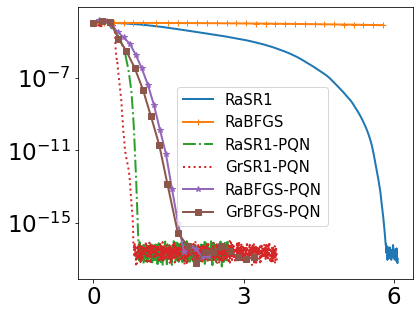

In [297]:
plt.rcParams['figure.figsize'] = (6, 5)
params = {'legend.fontsize': 15,
          'legend.handlelength': 2}
plt.rcParams.update(params)
plt.plot(tsr1[:1000],rsr1[:1000], '-', label='RaSR1',  linewidth=2)
plt.plot(tbroyden[:1500:50], rbfgs[:1500:50],'-+', label='RaBFGS', linewidth=2)
plt.plot(tsr1_fast[:1000],rsr_fast[:1000], '-.', label='RaSR1-PQN', linewidth=2)
plt.plot(tgsr_fast[:1000],grsr1[:1000], ':', label='GrSR1-PQN', linewidth=2)
plt.plot(tbroyfast1[:1000:50], rbfgs_fast[:1000:50], '-*', label='RaBFGS-PQN', linewidth=2)
plt.plot(tbroydr[:1000:50],grbfgs[:1000:50], '-s',label='GrBFGS-PQN', linewidth=2)
plt.tick_params(labelsize=23)
# plt.grid()
plt.legend()
plt.legend(bbox_to_anchor=(0.52, 0.45))
plt.yscale('log')
plt.xticks([0,3,6])
plt.savefig("Faira9awarm10000time.pdf",bbox_inches="tight",dpi=600,format="pdf")

## law school

In [298]:
m = loadmat('LSTUDENT_DATA1.mat')
A=np.array(m['A']).astype("float")
b=np.array(m['b']).astype("float")
b[np.where(b==0)[0]]=-1
c=np.array(m['c']).astype('float')
c[np.where(c==0)[0]]=-1
A=t.from_numpy(A).double()
b=t.from_numpy(b).double()
c=t.from_numpy(c).double()

In [324]:
oracle=Fairness_Learning(A,b,c,lamb=0.0001,gamma=0.0001,beta=0.5)

In [325]:
w0=t.zeros(oracle.d,1).double().to(device)
weg,reg,teg=Extra_gradiant(w0,0.1,0.1,30000)

epoches: 0 , gradient norm: 0.5687106292810119
epoches: 50 , gradient norm: 0.13005454698799632
epoches: 100 , gradient norm: 0.0634533936596134
epoches: 150 , gradient norm: 0.040184120993087324
epoches: 200 , gradient norm: 0.029703627879440822
epoches: 250 , gradient norm: 0.024264414534098507
epoches: 300 , gradient norm: 0.02109879977470702
epoches: 350 , gradient norm: 0.019045081448525316
epoches: 400 , gradient norm: 0.01757311696887792
epoches: 450 , gradient norm: 0.01642940625832468
epoches: 500 , gradient norm: 0.015487654264456453
epoches: 550 , gradient norm: 0.014681859698427934
epoches: 600 , gradient norm: 0.01397537253647258
epoches: 650 , gradient norm: 0.013346249205686762
epoches: 700 , gradient norm: 0.012780188426008459
epoches: 750 , gradient norm: 0.012267065926499619
epoches: 800 , gradient norm: 0.011799203577658679
epoches: 850 , gradient norm: 0.011370482540296751
epoches: 900 , gradient norm: 0.010975869588527193
epoches: 950 , gradient norm: 0.01061114692

In [326]:
z0=weg.to("cpu")

In [327]:
wb,rabroydfast,tbroyfast1=fast_randomBroyd_sol(z0.to(device),100,4000,1,True)

epoches:  0 gradient norm: 0.00044830619500218035
epoches:  50 gradient norm: 0.0004821242463594381
epoches:  100 gradient norm: 0.00045568532320788835
epoches:  150 gradient norm: 0.00042987384717641154
epoches:  200 gradient norm: 0.0003888315411069878
epoches:  250 gradient norm: 0.00035343004762664976
epoches:  300 gradient norm: 0.00030568702451389874
epoches:  350 gradient norm: 0.0002769044763331336
epoches:  400 gradient norm: 0.00023128679209690563
epoches:  450 gradient norm: 0.0002035960528973531
epoches:  500 gradient norm: 0.0001771235820847831
epoches:  550 gradient norm: 0.00014461863435330968
epoches:  600 gradient norm: 0.00012052800210001495
epoches:  650 gradient norm: 0.00010207022709329383
epoches:  700 gradient norm: 7.869913111561812e-05
epoches:  750 gradient norm: 6.137293178271459e-05
epoches:  800 gradient norm: 4.661124486329422e-05
epoches:  850 gradient norm: 3.5658758746709575e-05
epoches:  900 gradient norm: 2.3664237437836515e-05
epoches:  950 gradient 

In [328]:
w4, broyd_fast_gr, tbroydr = fast_greedyBroyd_sol(z0.to(device), 1000, 3000, 1 ,True)

epoches:  0 gradient norm: 0.0004483080118308038
epoches:  50 gradient norm: 0.00044803832172313516
epoches:  100 gradient norm: 0.00043992388011179366
epoches:  150 gradient norm: 0.0004084308127913002
epoches:  200 gradient norm: 0.0003972186550959192
epoches:  250 gradient norm: 0.0004263590491010032
epoches:  300 gradient norm: 0.0004850036159507682
epoches:  350 gradient norm: 0.0004920902631446288
epoches:  400 gradient norm: 5.44079073758887e-05
epoches:  450 gradient norm: 3.117762027477847e-05
epoches:  500 gradient norm: 2.3592379639578648e-05
epoches:  550 gradient norm: 1.2069458799927445e-05
epoches:  600 gradient norm: 8.171130600150118e-06
epoches:  650 gradient norm: 4.864575133272702e-06
epoches:  700 gradient norm: 3.5381089292993196e-06
epoches:  750 gradient norm: 9.593047498181968e-07
epoches:  800 gradient norm: 6.85910485218004e-08
epoches:  850 gradient norm: 9.92892751009872e-09
epoches:  900 gradient norm: 3.009323492622164e-10
epoches:  950 gradient norm: 7.4

In [329]:
wb,rbroyden,tbroyden=randomBroyden_sol(z0.to(device),10,3000,1,True)

epoches: 0 , gradient norm: 0.0004483082023503524
epoches: 50 , gradient norm: 0.00044814098714761444
epoches: 100 , gradient norm: 0.00044753726373679366
epoches: 150 , gradient norm: 0.0004462679240366485
epoches: 200 , gradient norm: 0.0004440286845057956
epoches: 250 , gradient norm: 0.0004418201265662533
epoches: 300 , gradient norm: 0.00043936639301145466
epoches: 350 , gradient norm: 0.00043589590366227213
epoches: 400 , gradient norm: 0.0004322322202433624
epoches: 450 , gradient norm: 0.00042864345801941014
epoches: 500 , gradient norm: 0.00042468420821399025
epoches: 550 , gradient norm: 0.0004185279722330645
epoches: 600 , gradient norm: 0.000413137910876541
epoches: 650 , gradient norm: 0.0004087654824466318
epoches: 700 , gradient norm: 0.00040371337604761816
epoches: 750 , gradient norm: 0.00039888294341204963
epoches: 800 , gradient norm: 0.0003938816087554412
epoches: 850 , gradient norm: 0.0003881353263652831
epoches: 900 , gradient norm: 0.0003828320405559556
epoches:

In [330]:
wsr_fast, rsr1_fast, tsr1_fast = fast_randomSR1_sol(z0.to(device), 100, 3000, 1, True)

epoches:  0 gradient norm: 0.00044830619500218035
epoches:  50 gradient norm: 0.000466460098731929
epoches:  100 gradient norm: 0.00047690018821431164
epoches:  150 gradient norm: 0.00041609879211691996
epoches:  200 gradient norm: 0.0003957734384438228
epoches:  250 gradient norm: 0.0003407373362676235
epoches:  300 gradient norm: 0.0002932375548634346
epoches:  350 gradient norm: 0.00027464725937528003
epoches:  400 gradient norm: 0.0002489577231213441
epoches:  450 gradient norm: 0.00020753272238342754
epoches:  500 gradient norm: 0.00018121622369836964
epoches:  550 gradient norm: 0.00015643286375377266
epoches:  600 gradient norm: 0.0001333690187357246
epoches:  650 gradient norm: 0.00011440148663515397
epoches:  700 gradient norm: 9.412156515619005e-05
epoches:  750 gradient norm: 7.445500526352452e-05
epoches:  800 gradient norm: 5.1607757134464285e-05
epoches:  850 gradient norm: 3.5238227140465606e-05
epoches:  900 gradient norm: 2.078357459563623e-05
epoches:  950 gradient no

In [331]:
wgsr_fast, gsr_fast, tgsr_fast = fast_greedySR1_sol(z0.to(device), 100, 3000, 1, True)

epoches:  0 gradient norm: 0.00044830619500218035
epoches:  50 gradient norm: 0.00044795370205349906
epoches:  100 gradient norm: 0.00043980821575572386
epoches:  150 gradient norm: 0.0004083108674069427
epoches:  200 gradient norm: 0.00039709228361214547
epoches:  250 gradient norm: 0.00042618558351592486
epoches:  300 gradient norm: 0.0004847920168061645
epoches:  350 gradient norm: 0.000491481936299604
epoches:  400 gradient norm: 2.9457600759728073e-05
epoches:  450 gradient norm: 2.2861663580322686e-05
epoches:  500 gradient norm: 1.9723833193488935e-05
epoches:  550 gradient norm: 8.21727634556817e-06
epoches:  600 gradient norm: 1.2182852865966708e-06
epoches:  650 gradient norm: 1.7733205537179204e-07
epoches:  700 gradient norm: 1.5725569173194067e-08
epoches:  750 gradient norm: 3.918920321835143e-10
epoches:  800 gradient norm: 1.1826764411954766e-17
epoches:  850 gradient norm: 2.9005073847045254e-18
epoches:  900 gradient norm: 8.223266593466781e-18
epoches:  950 gradient 

In [332]:
wsr1,rsr1,tsr1=randomSR1_sol(z0.to(device),100,3000,1,True)

epoches:  0 gradient norm: 0.0004483088530448822
epoches:  50 gradient norm: 0.0004421402583443495
epoches:  100 gradient norm: 0.000432605865907672
epoches:  150 gradient norm: 0.0004106090933581098
epoches:  200 gradient norm: 0.00039292304667960093
epoches:  250 gradient norm: 0.00036661671628979105
epoches:  300 gradient norm: 0.00034217145147762406
epoches:  350 gradient norm: 0.0003177396615266671
epoches:  400 gradient norm: 0.0002947210126030618
epoches:  450 gradient norm: 0.00027296278803139244
epoches:  500 gradient norm: 0.0002537554555034323
epoches:  550 gradient norm: 0.0002339750977927685
epoches:  600 gradient norm: 0.00021126208324336273
epoches:  650 gradient norm: 0.00019187147028648012
epoches:  700 gradient norm: 0.00017684008801932533
epoches:  750 gradient norm: 0.00016187296701039287
epoches:  800 gradient norm: 0.00014696581570437122
epoches:  850 gradient norm: 0.00013372215482261457
epoches:  900 gradient norm: 0.0001194760709642907
epoches:  950 gradient no

In [333]:
rsr1=np.array([x.item() for x in rsr1])
rsr_fast = np.array([x.item() for x in rsr1_fast])
grsr1=np.array([x.item() for x in gsr_fast])
rbfgs=np.array([x.item() for x in rbroyden])
rbfgs_fast=np.array([x.item() for x in rabroydfast])
grbfgs=np.array([x.item() for x in broyd_fast_gr])

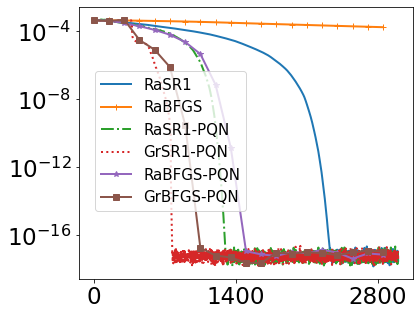

In [334]:
plt.rcParams['figure.figsize'] = (6, 5)
params = {'legend.fontsize': 15,
          'legend.handlelength': 2}
plt.rcParams.update(params)
plt.plot(rsr1[:3000], '-', label='RaSR1',  linewidth=2)
plt.plot(np.arange(0, len(rbfgs_fast[:3000]), 150), rbfgs[:3000:150],'-+', label='RaBFGS', linewidth=2)
plt.plot(rsr_fast[:3000], '-.', label='RaSR1-PQN', linewidth=2)
plt.plot(grsr1[:3000], ':', label='GrSR1-PQN', linewidth=2)
plt.plot(np.arange(0, len(rbfgs_fast[:3000]), 150), rbfgs_fast[:3000:150], '-*', label='RaBFGS-PQN', linewidth=2)
plt.plot(np.arange(0, len(rbfgs_fast[:3000]), 150),grbfgs[:3000:150], '-s',label='GrBFGS-PQN', linewidth=2)
plt.tick_params(labelsize=23)
# plt.grid()
plt.legend()
plt.legend(loc=(0.05, 0.25))
plt.yscale('log')
plt.xticks([0,1400,2800])
plt.yticks([1e-16,1e-12,1e-8,1e-4])
plt.savefig("Fairlawwarm30000res.pdf",bbox_inches="tight",dpi=600,format="pdf")

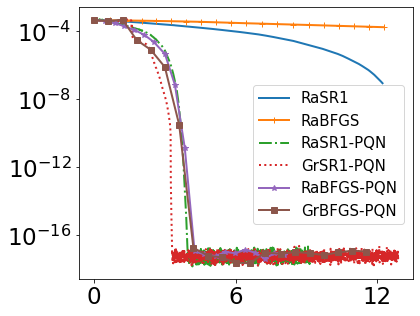

In [335]:
plt.rcParams['figure.figsize'] = (6, 5)
params = {'legend.fontsize': 15,
          'legend.handlelength': 2}
plt.rcParams.update(params)
plt.plot(tsr1[:2000],rsr1[:2000], '-', label='RaSR1',  linewidth=2)
plt.plot(tbroyden[:3000:150], rbfgs[:3000:150],'-+', label='RaBFGS', linewidth=2)
plt.plot(tsr1_fast[:3000],rsr_fast[:3000], '-.', label='RaSR1-PQN', linewidth=2)
plt.plot(tgsr_fast[:3000],grsr1[:3000], ':', label='GrSR1-PQN', linewidth=2)
plt.plot(tbroyfast1[:3000:150], rbfgs_fast[:3000:150], '-*', label='RaBFGS-PQN', linewidth=2)
plt.plot(tbroydr[:3000:150],grbfgs[:3000:150], '-s',label='GrBFGS-PQN', linewidth=2)
plt.tick_params(labelsize=23)
# plt.grid()
plt.legend()
plt.legend(loc=(0.52, 0.20))
plt.yscale('log')
plt.yticks([1e-16,1e-12,1e-8,1e-4])
plt.xticks([0,6,12])
plt.savefig("Fairlawwarm30000time.pdf",bbox_inches="tight",dpi=600,format="pdf")